<a href="https://colab.research.google.com/github/mertbkts/Covid19-Prediction-From-LungCT/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation For Training

 Importing Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

 Importing Dataset

In [3]:
dataset= "/content/drive/MyDrive/Dataset"

 Define Various Elements

In [4]:
# Configuration of Epoch and Batch Size for training
EpochNumber = 100
batchSize = 32

In [5]:
# Create a list from the paths of the images in the dataset
imagePaths = list(paths.list_images(dataset))

# Create separate lists for datas and labels
data = []
labels = []

Fetch Images and Labels of Them from The Filename They Belong(Either COVID or non-COVID)

In [6]:
print("Images are loading...")

for imagePath in imagePaths:
	
  # Fetch label of the current image
	label = imagePath.split(os.path.sep)[-2]

	# Read image
	image = cv2.imread(imagePath)
  # Change color channel to RGB
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Resize image to 224x224 pixels
	image = cv2.resize(image, (224, 224))
  
	# Append image and the label of it
	data.append(image)
	labels.append(label)

Images are loading...


Normalization

In [7]:
# Convert data to a NumPy array and normalize data between 0 and 1
data = np.array(data) / 255.0
labels = np.array(labels)

Train-Test Split

In [9]:
# Splitting data into training and test sets. 80% of the data will be the training set and 20% will be the test set.
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20)

One-Hot Encoding

In [10]:
# Categorize labels into zeros and ones
lb = LabelBinarizer()

trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)

testY = lb.fit_transform(testY)
testY = to_categorical(testY)

# Building The Model And Training

Building and Compiling The Model

In [12]:
# Building the base of the model using VGG19.
vggModel = VGG19(weights="imagenet", include_top=False,
                 input_tensor=Input(shape=(224, 224, 3)))

# Adding layers of Pooling, Flattening, Dropout and Fully Connected
output = vggModel.output
output = Flatten()(output)
output = Dropout(0.5)(output)
output = Dense(2, activation='softmax')(output)

model = Model(inputs=vggModel.input, outputs=output)

# Freezing layers to prevent modification of it's weights
for layer in vggModel.layers:
    layer.trainable = False

# Compiling the model
model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Increasing the size of data with techniques such as rotating, shifting, and flipping
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

80150528/80134624 [==============================] - 1s 0us/step


In [13]:
# Summarizing the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Training

In [14]:
H = model.fit(train_aug.flow(trainX, trainY, batch_size=batchSize),
                    validation_data=(testX, testY),
                    validation_steps=len(testX) / batchSize,
                    steps_per_epoch=len(trainX) / batchSize,
                    epochs=EpochNumber)

Epoch 1/100
62/62 [==============================] - 52s 614ms/step - loss: 0.9398 - accuracy: 0.6396 - val_loss: 0.7773 - val_accuracy: 0.6680
Epoch 2/100
62/62 [==============================] - 35s 564ms/step - loss: 0.5838 - accuracy: 0.7485 - val_loss: 0.3752 - val_accuracy: 0.8249
Epoch 3/100
62/62 [==============================] - 35s 560ms/step - loss: 0.5065 - accuracy: 0.7742 - val_loss: 0.4900 - val_accuracy: 0.7525
Epoch 4/100
62/62 [==============================] - 36s 574ms/step - loss: 0.4285 - accuracy: 0.8085 - val_loss: 0.3355 - val_accuracy: 0.8491
Epoch 5/100
62/62 [==============================] - 37s 591ms/step - loss: 0.4217 - accuracy: 0.8024 - val_loss: 0.3135 - val_accuracy: 0.8612
Epoch 6/100
62/62 [==============================] - 36s 581ms/step - loss: 0.4476 - accuracy: 0.8044 - val_loss: 0.3366 - val_accuracy: 0.8531
Epoch 7/100
62/62 [==============================] - 36s 572ms/step - loss: 0.4551 - accuracy: 0.8160 - val_loss: 0.2886 - val_accuracy:

Saving The Model

In [15]:
# Saving the model and it's weights
model.save('model.h5')
model.save_weights('weights.hdf5')

# Testing And Statistics

Prediction Test

In [16]:
# Predicting on test set
predTest = model.predict(testX, batch_size=batchSize)

In [17]:
# Converting results to binary classes for confusion matrix calculation
predTest = np.argmax(predTest, axis=1)

Statistics

In [18]:
# Creating classification report for performance evaluation
print(classification_report(testY.argmax(axis=1), predTest,
	target_names=lb.classes_))


              precision    recall  f1-score   support

       covid       0.83      0.98      0.89       252
      normal       0.97      0.79      0.87       245

    accuracy                           0.88       497
   macro avg       0.90      0.88      0.88       497
weighted avg       0.90      0.88      0.88       497



In [19]:
# Calculating confusion matrix, accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [20]:
# Printing calculations
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[246   6]
 [ 52 193]]
acc: 0.8833
sensitivity: 0.9762
specificity: 0.7878


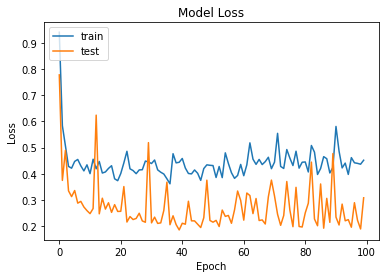

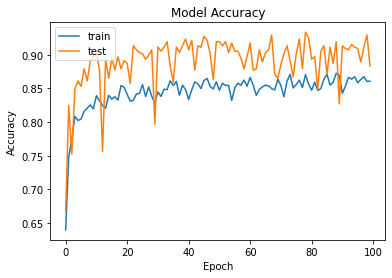

In [24]:
# Visualizing model's training history
N = EpochNumber

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("plotloss.png")
plt.show()



plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("plotaccuracy.png")
plt.show()
